# 🌍 GeoViT: A Convolutional-Transformer Model for Geolocation Estimation

Welcome to the GeoViT project notebook!

This notebook presents the training, evaluation, and experimentation pipeline for **GeoViT**, a neural network model designed to **predict geographic locations from Google Street View images**. The model takes inspiration from the popular game *Geoguessr* and is trained using the [OpenStreetView-5M dataset](https://huggingface.co/datasets/osv5m/osv5m).

🖊️ Authors: Alan Tran and Caleb Wolf

---

## 📌 Project Goals

1. **Train** a hybrid convolutional-transformer model that can learn geospatial patterns from street-level imagery.
2. **Evaluate** the model using geodesic distance-based metrics.
3. **Experiment** with:
   - Vision Transformer ablations (layers & attention heads)
   - Robustness to reduced image context (square vs 3:2 aspect ratio)

---

## 🧠 Model Overview

- **Convolutional Frontend:** Captures local texture and object-level features.
- **Vision Transformer (ViT):** Captures global spatial dependencies.
- **Output:** Regressed GPS coordinates (Latitude, Longitude)

---

## 🧪 Experiments

### ✅ Experiment 1: ViT Ablation
- Reduce number of transformer layers and attention heads
- Assess contribution of transformer structure to geolocation performance

### ✅ Experiment 2: Robustness to Cropped Context
- Evaluate model on square images (less context)
- Compare against standard aspect ratio input

---

## Hybrid CNN-ViT Model Training

In [26]:
import os
import glob
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torchvision.models as models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import timm
from s2sphere import LatLng, CellId
import heapq
import csv
import numpy as np
from torch.utils.tensorboard import SummaryWriter

In [3]:
# Class that maps cells to grid indices
class Region:
    __slots__ = ('cell_id','level','indices')
    def __init__(self, cell_id, level, indices):
        self.cell_id = cell_id      # an s2sphere.CellId
        self.level   = level        # integer level
        self.indices = indices      # list of DataFrame indices
    def count(self): 
        return len(self.indices)
    def split(self, df, lat_col, lon_col):
        """Split into children at level+1 and group membership."""
        next_level = self.level + 1
        groups = {}
        for i in self.indices:
            lat, lon = df.at[i, lat_col], df.at[i, lon_col]
            cid = CellId.from_lat_lng(LatLng.from_degrees(lat, lon)) \
                         .parent(next_level)
            groups.setdefault(cid.id(), []).append(i)
        return [
            Region(CellId(child_id), next_level, idxs)
            for child_id, idxs in groups.items()
        ]

def build_planet_partitions(
    train_df: pd.DataFrame,
    lat_col: str = 'latitude',
    lon_col: str = 'longitude',
    t1: int = 10000,
    t2: int = 50
):
    """
    Performs PlaNet‐style adaptive partitioning on train_df,
    returns (labels, kept_regions):
      - labels: pd.Series of length train_df, with class 0…K-1 (or -1)
      - kept_regions: list of Region objects whose cells were kept (count >= t2)
    """
    # 1) Seed with level=0 roots
    root_ids = train_df.apply(
        lambda r: CellId
            .from_lat_lng(LatLng.from_degrees(r[lat_col], r[lon_col]))
            .parent(0)
            .id(),
        axis=1
    )
    roots = [
        Region(CellId(rid), 0, idxs.tolist())
        for rid, idxs in root_ids.groupby(root_ids).groups.items()
    ]

    # 2) Recursively split any region > t1

    # include cell_id.id() as a tie-breaker
    heap = [(-r.count(),  r.cell_id.id(),  r) for r in roots]
    heapq.heapify(heap)

    leaves = []
    while heap:
        negc, _, region = heapq.heappop(heap)
        if region.count() > t1:
            for child in region.split(train_df, lat_col, lon_col):
                # push with the same tuple structure
                heapq.heappush(heap, (-child.count(), child.cell_id.id(), child))
        else:
            leaves.append(region)

    # 3) Prune leaves < t2
    kept = [r for r in leaves if r.count() >= t2]

    # 4) Assign train labels
    train_labels = pd.Series(-1, index=train_df.index, dtype=int)
    for cls_idx, region in enumerate(kept):
        train_labels.loc[region.indices] = cls_idx

    return train_labels, kept

def assign_planet_labels(
    df: pd.DataFrame,
    regions: list,
    lat_col: str = 'latitude',
    lon_col: str = 'longitude',
) -> pd.Series:
    """
    Given any df and a list of kept Region objects (from build_planet_partitions),
    returns a pd.Series of –1 or 0…K-1 depending on which region each point falls into.
    """
    # Group regions by their level for faster lookup
    by_level = {}
    for cls_idx, reg in enumerate(regions):
        by_level.setdefault(reg.level, {})[reg.cell_id.id()] = cls_idx

    labels = pd.Series(-1, index=df.index, dtype=int)

    # For each unique level, compute all cell_ids in bulk and map
    for level, mapping in by_level.items():
        # compute cell_id.id() at this level for every point
        ids = df.apply(
            lambda r: CellId
                .from_lat_lng(LatLng.from_degrees(r[lat_col], r[lon_col]))
                .parent(level)
                .id(),
            axis=1
        )
        # map to class_idx (NaN becomes -1)
        mapped = ids.map(mapping).fillna(-1).astype(int)
        # only overwrite labels that are still -1
        mask = (labels == -1) & (mapped >= 0)
        labels.loc[mask] = mapped.loc[mask]

    return labels


In [19]:
# Import data
DATA_ROOT = 'osv5m/'
TRAIN_CSV = os.path.join(DATA_ROOT, 'train_mini.csv')
TEST_CSV = os.path.join(DATA_ROOT, 'test_mini.csv')
TRAIN_IMG_DIR = os.path.join(DATA_ROOT, 'train_images')
TEST_IMG_DIR = os.path.join(DATA_ROOT, 'test_images')

# Set global parameters
EPOCHS = 20
BATCH_SIZE = 64
L = 10
LABEL_COL = 'planet_class'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Read CSV files
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

# Build partitions on train and test
train_labels, kept_regions = build_planet_partitions(
    train_df, lat_col='latitude', lon_col='longitude',
    t1=100, t2=20
)
train_df[LABEL_COL] = train_labels
train_df = train_df[train_labels >= 0].reset_index(drop=True)

test_labels = assign_planet_labels(
    test_df, kept_regions, lat_col='latitude', lon_col='longitude'
)
test_df[LABEL_COL] = test_labels
test_df = test_df[test_labels >= 0].reset_index(drop=True)

In [5]:
print(train_df[LABEL_COL].unique()[:5])
print(train_df[LABEL_COL].nunique())

[ 88 668 884 311 985]
2199


In [6]:
# Define CNN + ViT hybrid model for geospatial classification
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Conv feature extractor (ResNet50)
        self.cnn = timm.create_model("resnet50", pretrained=True, features_only=True)
        cnn_out_channels = self.cnn.feature_info[-1]['num_chs']

        # ViT block (tiny patch-based attention)
        self.vit = timm.create_model("vit_small_patch16_224", pretrained=True)
        self.vit.head = nn.Identity()  # remove classifier

        # Fusion + Classifier
        self.pool = nn.AdaptiveAvgPool2d((14, 14))
        self.proj = nn.Linear(cnn_out_channels, self.vit.embed_dim)

        self.dropout = nn.Dropout(p=0.2) # Dropout Regularization
        self.classifier = nn.Linear(self.vit.embed_dim, num_classes)

    def forward(self, x):
        # Get last feature map from CNN
        x = self.cnn(x)[-1]  # shape (B, C, H, W)

        # Pool to fixed 14 x 14 size
        x = self.pool(x)  # shape (B, C, 14, 14)

        # Flatten and transpose to patch seq format that matches ViT input
        x = x.flatten(2).transpose(1, 2)  # (B, C, H*W) -> (B, H*W, C)

        # Project to ViT embedding dim
        x = self.proj(x)  # shape (B, 196, D)

        # Feed through ViT encoder blocks
        x = self.vit.blocks(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.dropout(x)

        return self.classifier(x)
    
# Define the geospatial dataset class
class GeoDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        images_root: str,
        nclasses: int,
        label_col: str = 'planet_class',
        transforms=None
    ):
        # 1) keep only valid labels (>=0)
        self.df = df[df[label_col] >= 0].reset_index(drop=True)

        self.label_col = label_col
        self.classes = nclasses

        # 3) build a map from image‐ID → full path
        all_files = glob.glob(os.path.join(images_root, '*', '*.jpg'))
        self.id2path = {
            os.path.splitext(os.path.basename(p))[0]: p
            for p in all_files
        }

        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row    = self.df.iloc[idx]
        img_id = str(row['id'])
        label  = int(row[self.label_col])
        img    = Image.open(self.id2path[img_id]).convert('RGB')
        if self.transforms:
            img = self.transforms(img)
        return img, label

In [20]:
# Transformations for training data augmentation (better generalization)
train_transforms = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# Transformations for test data (no augmentation)
test_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Instantiate the dataset and dataloaders
train_ds = GeoDataset(
    df          = train_df,
    images_root = TRAIN_IMG_DIR,
    label_col   = LABEL_COL,
    nclasses=len(kept_regions),
    transforms  = train_transforms
)

test_ds = GeoDataset(
    df          = test_df,
    images_root = TEST_IMG_DIR,
    label_col   = LABEL_COL,
    nclasses=len(kept_regions),
    transforms  = test_transforms
)

print(f"Softmax size (num classes) = {train_ds.classes}")  # same for both

num_val = int(0.1 * len(train_ds)) # 90% training set, 10% testing set
num_train = len(train_ds) - num_val
train_subset, val_subset = random_split(train_ds, [num_train, num_val], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_subset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,      batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Model
model = CNN_ViT_Hybrid(num_classes=train_ds.classes).to(device)
criterion = nn.CrossEntropyLoss()

# Freeze ResNet
for param in model.cnn.parameters():
    param.requires_grad = False

# Freeze ViT
for param in model.vit.parameters():
    param.requires_grad = False

# Create optimizer only for trainable layers (ViT projection + classifier)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4, 
    weight_decay=1e-4
)

# Learning rate scheduler
# Reduce learning rate when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,   # reduce LR by half
    patience=2,   # wait 2 epochs with no val loss improvement
    verbose=True
)

Softmax size (num classes) = 2199


c:\Users\alan\anaconda3\envs\NN1\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
# Get dimensions of training batch
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [56]:
# Training and evaluation functions
def train_one_epoch(model, loader):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        correct += outputs.argmax(1).eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    correct_pred_idx = []
    current_index = 0  # global index tracker

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

            for i in range(len(preds)):
                if preds[i] == labels[i]:
                    correct_pred_idx.append(current_index + i)

            current_index += len(preds)

    return running_loss / total, correct / total, correct_pred_idx

In [23]:
log_file = open("training_log.csv", mode="a", newline="")
logger = csv.writer(log_file)
logger.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "lr"])

# TensorBoard writer for visualizing metrics
writer = SummaryWriter("runs/geo_model_experiment")

model.load_state_dict(torch.load("hybrid_best_model_epoch16.pth"))
model.to(device)

best_val_acc = 0.3250
best_val_loss = 3.2312
# --- Training Loop ---
for epoch in range(16, EPOCHS):
    print(f"\n🌍 Epoch {epoch+1}/{EPOCHS}")

    # Unfreeze layers after 3 epochs
    if epoch == 3:
        print("🔓 Unfreezing layers...")
        for param in model.cnn.parameters():
            param.requires_grad = True
        for param in model.vit.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()), 
            lr=1e-5,
            weight_decay=1e-4
        )

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2,
            verbose=True
        )

    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc     = evaluate(model, val_loader)

    # Log scheduler learning rate
    scheduler.step(val_loss)
    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")

    # Save metrics to CSV file
    current_lr = optimizer.param_groups[0]['lr']
    logger.writerow([epoch+1, train_loss, train_acc, val_loss, val_acc, current_lr])
    log_file.flush()  # ensures it's written to disk

    # Log metrics to TensorBoard
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)

    for param_group in optimizer.param_groups:
        writer.add_scalar("Learning Rate", param_group['lr'], epoch)



    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_loss < best_val_loss or val_acc > best_val_acc:
        best_val_loss = val_loss
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"hybrid_best_model_epoch{epoch+1}.pth")
        print("✅ Saved best model.")

log_file.close()
writer.close()

C:\Users\alan\AppData\Local\Temp\ipykernel_8052\2996457939.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("hybrid_best_model_epoch16.pt


🌍 Epoch 17/20


100%|██████████| 1583/1583 [22:27<00:00,  1.17it/s]


Current learning rate: 0.0001
Train Loss: 2.8023, Acc: 0.3822
Val   Loss: 3.1983, Acc: 0.3266
✅ Saved best model.

🌍 Epoch 18/20


100%|██████████| 1583/1583 [17:51<00:00,  1.48it/s]


Current learning rate: 0.0001
Train Loss: 2.7328, Acc: 0.3943
Val   Loss: 3.1607, Acc: 0.3410
✅ Saved best model.

🌍 Epoch 19/20


100%|██████████| 1583/1583 [20:45<00:00,  1.27it/s]


Current learning rate: 0.0001
Train Loss: 2.6605, Acc: 0.4051
Val   Loss: 3.1057, Acc: 0.3437
✅ Saved best model.

🌍 Epoch 20/20


100%|██████████| 1583/1583 [22:33<00:00,  1.17it/s]


Current learning rate: 0.0001
Train Loss: 2.6142, Acc: 0.4102
Val   Loss: 3.1068, Acc: 0.3438
✅ Saved best model.


🌍 Epoch 6/10
100%|██████████| 3166/3166 [26:56<00:00,  1.96it/s]
Current learning rate: 0.0001
Train Loss: 5.1646, Acc: 0.1002
Val   Loss: 4.6061, Acc: 0.1496
✅ Saved best model.

🌍 Epoch 7/10
100%|██████████| 3166/3166 [21:32<00:00,  2.45it/s]
Current learning rate: 0.0001
Train Loss: 4.5202, Acc: 0.1492
Val   Loss: 4.2192, Acc: 0.1907
✅ Saved best model.

🌍 Epoch 9/10
100%|██████████| 3166/3166 [17:45<00:00,  2.97it/s]
Current learning rate: 0.0001
Train Loss: 3.9185, Acc: 0.2158
Val   Loss: 3.8253, Acc: 0.2363
✅ Saved best model.

🌍 Epoch 10/10
100%|██████████| 3166/3166 [17:44<00:00,  2.97it/s]
Current learning rate: 0.0001
Train Loss: 3.7284, Acc: 0.2397
Val   Loss: 3.7004, Acc: 0.2514
✅ Saved best model.

🌍 Epoch 11/15
100%|██████████| 3166/3166 [18:15<00:00,  2.89it/s]
Current learning rate: 0.0001
Train Loss: 3.5743, Acc: 0.2618
Val   Loss: 3.5668, Acc: 0.2738
✅ Saved best model.

🌍 Epoch 12/15
100%|██████████| 3166/3166 [18:06<00:00,  2.91it/s]
Current learning rate: 0.0001
Train Loss: 3.4266, Acc: 0.2819
Val   Loss: 3.4764, Acc: 0.2845
✅ Saved best model.

🌍 Epoch 13/15
100%|██████████| 3166/3166 [22:35<00:00,  2.34it/s]
Current learning rate: 0.0001
Train Loss: 3.3198, Acc: 0.2963
Val   Loss: 3.4377, Acc: 0.2873
✅ Saved best model.

🌍 Epoch 14/15
100%|██████████| 3166/3166 [26:04<00:00,  2.02it/s]
Current learning rate: 0.0001
Train Loss: 3.2206, Acc: 0.3098
Val   Loss: 3.3822, Acc: 0.2968
✅ Saved best model.

🌍 Epoch 15/15
100%|██████████| 3166/3166 [24:24<00:00,  2.16it/s]
Current learning rate: 0.0001
Train Loss: 3.1338, Acc: 0.3242
Val   Loss: 3.3237, Acc: 0.3075
✅ Saved best model.

🌍 Epoch 16/20
100%|██████████| 1583/1583 [20:24<00:00,  1.22it/s]
Current learning rate: 0.0001
Train Loss: 2.9151, Acc: 0.3659
Val   Loss: 3.2312, Acc: 0.3250
✅ Saved best model.

In [73]:
model.load_state_dict(torch.load('hybrid_best_model_epoch20.pth'))
model.to(device)

for param in model.cnn.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True


# Only params that require gradients
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(trainable_params, lr=1e-5) # reinitialize optimizer

# --- Fine-tuning with frozen layers ---
fine_tune_epochs = 3
start_epoch = 20
best_val_loss = float('inf')
best_val_acc = 0.0

for epoch in range(start_epoch, start_epoch + fine_tune_epochs):
    print(f"\n🎯 Fine-tuning Epoch {epoch+1}/{start_epoch + fine_tune_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc, correct_indices     = evaluate(model, val_loader)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_loss < best_val_loss or val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"hybrid_best_model_epoch{epoch+1}.pth")
        print("✅ Saved best model.")

C:\Users\alan\AppData\Local\Temp\ipykernel_8052\3125098846.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('hybrid_best_model_epoch20.pt


🎯 Fine-tuning Epoch 21/22


100%|██████████| 1583/1583 [22:03<00:00,  1.20it/s]


Train Loss: 2.4489, Acc: 0.4439
Val   Loss: 3.0341, Acc: 0.3596
✅ Saved best model.

🎯 Fine-tuning Epoch 22/22


100%|██████████| 1583/1583 [20:58<00:00,  1.26it/s]


Train Loss: 2.4089, Acc: 0.4543
Val   Loss: 3.0418, Acc: 0.3574
✅ Saved best model.

🎯 Fine-tuning Epoch 23/22


100%|██████████| 1583/1583 [20:20<00:00,  1.30it/s]


Train Loss: 2.3900, Acc: 0.4564
Val   Loss: 2.9985, Acc: 0.3601
✅ Saved best model.


After training, go to the terminal bash and run: tensorboard --logdir=runs
in order to see visualizations. Then go to http://localhost:6006

In [ ]:
# --- Final Test ---
test_loss, test_acc, correct_indices = evaluate(model, test_loader)
print(f"\n✅ Final Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

In [ ]:
# Fine Tune with frozen layers
# Load the best model from the previous training
# model.load_state_dict(torch.load('no-freeze\hybrid_best_model_epoch5.pth'))
# model.to(device)

for param in model.cnn.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True


# Only params that require gradients
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(trainable_params, lr=1e-5) # reinitialize optimizer

# --- Fine-tuning with frozen layers ---
fine_tune_epochs = 3
start_epoch = 15
best_val_loss = float('inf')
best_val_acc = 0.0

for epoch in range(start_epoch, start_epoch + fine_tune_epochs):
    print(f"\n🎯 Fine-tuning Epoch {epoch}/{start_epoch + fine_tune_epochs - 1}")
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc     = evaluate(model, val_loader)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_loss < best_val_loss or val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"hybrid_best_model_epoch{epoch+1}.pth")
        print("✅ Saved best model.")


## Experiment 1: Ablations and Heat Map

C:\Users\alan\AppData\Local\Temp\ipykernel_8052\34333901.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("hybrid_best_model_epoch20.pth

1139 correct predictions, choosing sample 2201 out of 7287


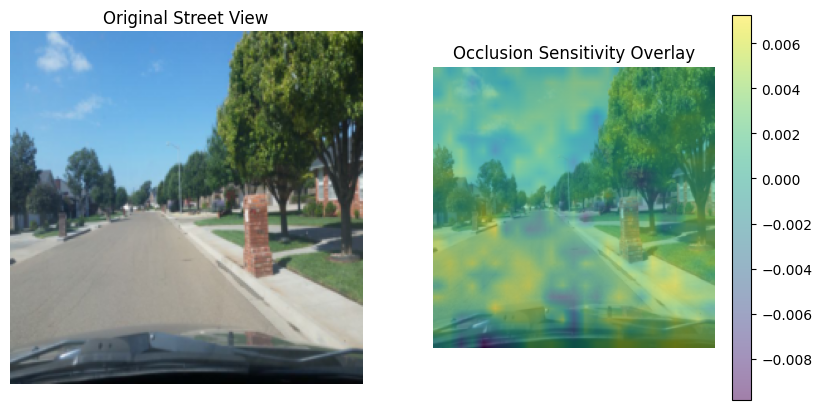

In [69]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

def compute_occlusion_map(
    model,
    image,            # C×H×W tensor, already normalized
    label,            # true‐class int
    patch_size=32,
    stride=16,
    occlusion_value=0
):
    model.eval()
    device = next(model.parameters()).device
    image = image.to(device)
    with torch.no_grad():
        out = model(image.unsqueeze(0))
        p0  = F.softmax(out, dim=1)[0, label].item()

    _, H, W  = image.shape
    n_rows   = (H - patch_size)//stride + 1
    n_cols   = (W - patch_size)//stride + 1
    heatmap  = torch.zeros((n_rows, n_cols), device=device)

    for i in range(n_rows):
        for j in range(n_cols):
            top, left = i*stride, j*stride
            occ = image.clone()
            occ[:, top:top+patch_size, left:left+patch_size] = occlusion_value
            with torch.no_grad():
                out_ij = model(occ.unsqueeze(0))
                prob   = F.softmax(out_ij, dim=1)[0, label].item()
            heatmap[i, j] = p0 - prob

    heatmap = heatmap.unsqueeze(0).unsqueeze(0)
    heatmap = F.interpolate(heatmap, size=(H, W), mode='bilinear', align_corners=False)
    return heatmap.squeeze().cpu().numpy()


# load the model
model.load_state_dict(torch.load("hybrid_best_model_epoch20.pth"))
model.to(device)

# Grab one sample
# idx = random.choice(correct_indices)
idx = 2201 
print(f"{len(correct_indices)} correct predictions, choosing sample {idx} out of {len(test_ds)}")
img, label = train_ds[idx]


# Unnormalize for display
mean = torch.tensor([.485, .456, .406]).view(3,1,1)
std  = torch.tensor([.229, .224, .225]).view(3,1,1)
img_disp = img * std + mean
img_np   = np.transpose(img_disp.numpy(), (1,2,0))

# Compute occlusion map
heatmap = compute_occlusion_map(model, img, label, patch_size=32, stride=8, occlusion_value=0)

# Plot side‐by‐side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Original image
ax1.imshow(img_np)
ax1.axis('off')
ax1.set_title('Original Street View')

# Overlay heatmap on the original image
ax2.imshow(img_np)  # Base image
im = ax2.imshow(heatmap, cmap='viridis', alpha=0.5)  # Overlay with transparency
ax2.axis('off')
ax2.set_title('Occlusion Sensitivity Overlay')

# Colorbar
fig.colorbar(im, ax=ax2)



C:\Users\alan\AppData\Local\Temp\ipykernel_8052\3724964073.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("hybrid_best_model_epoch5.pth

1139 correct predictions, choosing sample 2201 out of 7287


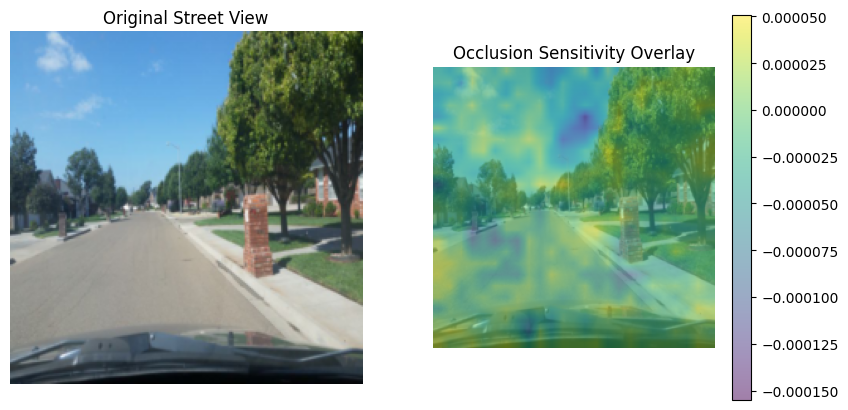

In [71]:
# load the model
model.load_state_dict(torch.load("hybrid_best_model_epoch5.pth"))
model.to(device)

# Grab one sample
# idx = random.choice(correct_indices)
idx = 2201 
print(f"{len(correct_indices)} correct predictions, choosing sample {idx} out of {len(test_ds)}")
img, label = train_ds[idx]


# Unnormalize for display
mean = torch.tensor([.485, .456, .406]).view(3,1,1)
std  = torch.tensor([.229, .224, .225]).view(3,1,1)
img_disp = img * std + mean
img_np   = np.transpose(img_disp.numpy(), (1,2,0))

# Compute occlusion map
heatmap = compute_occlusion_map(model, img, label, patch_size=32, stride=8, occlusion_value=0)

# Plot side‐by‐side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Original image
ax1.imshow(img_np)
ax1.axis('off')
ax1.set_title('Original Street View')

# Overlay heatmap on the original image
ax2.imshow(img_np)  # Base image
im = ax2.imshow(heatmap, cmap='viridis', alpha=0.5)  # Overlay with transparency
ax2.axis('off')
ax2.set_title('Occlusion Sensitivity Overlay')

# Colorbar
fig.colorbar(im, ax=ax2)



## Experiment 2: Model Probability Distribution on US Map